<a href="https://colab.research.google.com/github/Hesh0629/Hesh0629/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

나는 그림은 못그리지만 손꾸락은 달려있지  
*Neural Style Transfer*  
  
2021.04.24

In [10]:
import keras
from keras.preprocessing.image import load_img, img_to_array, save_img
target_image_path='/content/drive/MyDrive/20200408_202404_482.jpg'

style_ref_image_path='/content/drive/MyDrive/R800x0-2.jpg'

width,height=load_img(target_image_path).size
img_height=400;
img_width=int(width*img_height/height)

In [3]:
import numpy as np
from keras.applications import vgg19
import tensorflow as tf
tf.compat.v1.disable_eager_execution() #에러 방지용. 안그러면 K.gradients() 이용 불가

def preprocess_image (image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0) #배치 차원 만들어야해서 하나 더 추가
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  # ImageNet의 평균 픽셀 값을 더합니다
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8') # clip으로 0보다 작은값들과 255보다 큰 값들을 안쪽으로 위치
  return x

In [4]:
from keras import backend as K

#요 둘은 고정이므로 k.constatnt 이용, k.placeholder는 가변
target_image = K.constant(preprocess_image(target_image_path)) #고정으로 쓸거라 constant에 담는데 왜 백엔드까지 써서 담는지는 아직 모르겠다.
style_ref_image = K.constant(preprocess_image(style_ref_image_path))

combination_image = K.placeholder((1,img_height,img_width,3)) #일종의 담는 그릇이라 생각하면 될듯...? (행렬 형태로)

input_tensor=K.concatenate([target_image,
                            style_ref_image,
                            combination_image],axis=0) #하나로 합쳐버림, [0]=target,[1]=style_ref,[2]=combination (because concatenate by axis=0)

model=vgg19.VGG19(input_tensor=input_tensor,
                  weights='imagenet', #나중에 한번 쓱 바꿔봐야겠다. 기본적으로만 이미지넷이 있고 추가 다운로드 해야함. 화가들 모아둔거 있으면 뒤적뒤적 해봐야겠다.
                  include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [6]:
def content_loss(base, combination):
  return K.sum(K.square(combination-base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x,(2,0,1))) # i,j,k를 각각 0,1,2로 보고 k,i,j순서로 축변환 진행
  gram = K.dot(features,K.transpose(features))
  return gram

def style_loss(style, combination):
  s = gram_matrix(style)
  c = gram_matrix(combination)
  channels = 3 # R G B
  size = img_height *img_width
  return K.sum(K.square(s-c))/(4*(channels ** 2)* (size**2))

def total_variation_loss(x): #생성된 이미지의 픽셀을 이용하여 총 변위 손실 계산 -> 픽셀 격자무늬 생성 억제
  a = K.square(
      x[:,:img_height-1,:img_width-1,:]-x[:,1:,:img_width-1,:])
  b = K.square(
      x[:,:img_height-1,:img_width-1,:]-x[:,:img_height-1,1:,:])
  return K.sum(K.pow(a+b,1.25))

In [20]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층 (출력 직전 부분)
content_layer = 'block5_conv2' 

# 스타일 손실에 사용할 층(풀링 후 첫 부분)
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4  #만약 픽셀 테두리가 보인다면 높일 것 (default = 1e-4)
style_weight = 1.
content_weight = 0.075  #사용하는 이미지들에 따라 조정, 높을수록 생성된 이미지에 타깃 콘텐츠가 많이 나타남

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

#content loss구하는 방법
loss = loss+content_weight * content_loss(target_image_features,
                                      combination_features)

#스타일 loss 구하는 방법
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

#총 변위 손실(픽셀) 구하는 방법
loss += total_variation_weight * total_variation_loss(combination_image)

# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [8]:
#Evaluator 정의.
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

fmin_l_bfgs_b reference:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 100

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0


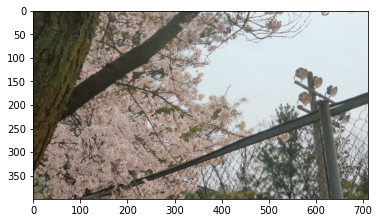

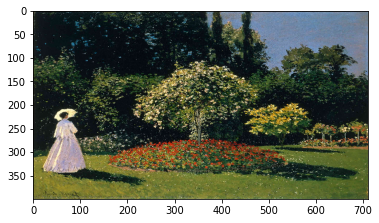

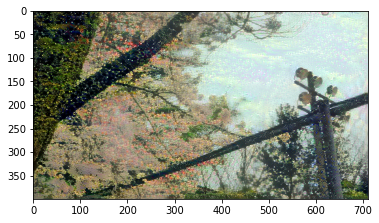

In [23]:
from matplotlib import pyplot as plt
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_ref_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()